In [2]:
import numpy as np

# two d=3 qudits

In [3]:
n_qudits = 2
d = 3

### Generate "unkown" state you want to learn

In [4]:
def random_complex_vector(n):
    # Generate random real and imaginary parts
    real_part = np.random.uniform(low=-1, high=1, size=n)
    imag_part = np.random.uniform(low=-1, high=1, size=n)
    
    # Combine them to form a complex vector
    vector = real_part + 1j * imag_part
    
    # Normalize the vector to have norm = 1
    norm = np.linalg.norm(vector)
    normalized_vector = vector / norm
    
    return normalized_vector

psi = random_complex_vector(d**n_qudits).reshape(-1, 1)
unkown_dm = psi @ psi.conj().T

### Define measurement bases 

In [5]:
zero = np.array([1, 0, 0]).reshape(-1, 1)
one = np.array([0, 1, 0]).reshape(-1, 1)
two = np.array([0, 0, 1]).reshape(-1, 1) 

plus_zero_one = 1/np.sqrt(2) * np.array([1, 1, 0]).reshape(-1, 1)
i_zero_one = 1/np.sqrt(2) * np.array([1, 1j, 0]).reshape(-1, 1)

plus_zero_two = 1/np.sqrt(2) * np.array([1, 0, 1]).reshape(-1, 1)
i_zero_two = 1/np.sqrt(2) * np.array([1, 0, 1j]).reshape(-1, 1)

basis_states = [zero, one, two,
                plus_zero_one, i_zero_one,
                plus_zero_two, i_zero_two]

### Create measurement projectors

In [6]:
# 2 qubits
measurement_operators = [state_vector @ state_vector.conj().T for state_vector in basis_states]
two_qubit_measurement_operators = []
for qubit_1_op in measurement_operators:
    for qubit_2_op in measurement_operators:
        two_qubit_measurement_operators.append(np.kron(qubit_1_op, qubit_2_op))

### Compute probabilities to use as the data to fit to
Experimentally, you would compute these from measurement counts

In [7]:
def get_probabilities(dm):
    return [np.trace(dm @ measurement_op).real for measurement_op in two_qubit_measurement_operators]

probabilities = get_probabilities(unkown_dm)

### Create tunable state
Parameterization from: https://research.physics.illinois.edu/QI/Photonics/tomography-files/tomo_chapter_2004.pdf

In [61]:
def get_parameterized_dm(t):
    """ t is a list of the tunable parameters. Returns a lower triangular matrix with complex elements below the diagonal
    real elements on the diagonal. """
    T = np.zeros((9, 9), dtype=np.complex_)
    index = 0 
    for i, row in enumerate(T):
        for j in range(len(row)):
            if j < i:
                T[i, j] = t[index] + 1j*t[index + 1]
                index += 2
            elif i == j:
                T[i, j] = t[index]
                index += 1
            else:
                continue

    parameterized_rho = (T.conj().T @ T) / np.trace(T.conj().T @ T)
    return parameterized_rho

In [62]:
dm_parameters = np.random.uniform(low=-1, high=1, size=d**n_qudits**2)

In [63]:
parameterized_dm = get_parameterized_dm(dm_parameters)

In [64]:
for row in parameterized_dm:
    print(row)

[ 0.21211156+1.63980463e-18j  0.0070722 -2.56591849e-02j
 -0.03252861+3.58437731e-03j  0.02447713-2.32295179e-02j
 -0.01602424+1.68329198e-02j -0.02617593+8.74762073e-03j
 -0.01911542+3.19373195e-02j -0.00725381-2.93313941e-02j
  0.00062912+9.11903709e-03j]
[ 0.0070722 +2.56591849e-02j  0.21224345-8.05353695e-19j
  0.01844274-4.48895384e-03j -0.00704249+1.82378339e-02j
  0.03867756-1.39653503e-02j -0.04485753+3.72134069e-02j
 -0.0479968 +3.29303738e-02j  0.01595779-4.03916382e-02j
 -0.00939898+8.27942547e-03j]
[-0.03252861-3.58437731e-03j  0.01844274+4.48895384e-03j
  0.15474758+1.14922167e-18j  0.02668696-1.44268730e-03j
 -0.04244732+2.97979611e-02j  0.01666054-2.02359579e-02j
  0.0188404 +6.82909245e-03j -0.01149327+4.02228301e-04j
  0.00224052-5.06468089e-05j]
[ 0.02447713+2.32295179e-02j -0.00704249-1.82378339e-02j
  0.02668696+1.44268730e-03j  0.17325813-1.61976169e-18j
 -0.04790371-1.40044151e-02j  0.03654889-8.82772026e-03j
 -0.00765896+3.25406976e-02j -0.00692899-6.41731977e-03

### Test that DM is valid

In [65]:
# Check that trace is close to one
assert np.allclose(1, np.trace(parameterized_dm))

# Check Hermitian
assert np.allclose(parameterized_dm, parameterized_dm.conj().T)

# Check positive-semi definite <--> eigenvalues >= 0
assert np.all(np.linalg.eigvalsh(parameterized_dm) >= 0)

### Optimize with SciPy

In [66]:
def get_probabilites_from_parameters(t):
    parameterized_dm = get_parameterized_dm(t)
    probabilities = get_probabilities(parameterized_dm)
    return probabilities

In [67]:
from scipy.special import kl_div

def kl_divergence(true_probs, t):
    probs = get_probabilites_from_parameters(t)
    return sum(kl_div(true_probs, probs))

kl_divergence_from_parameters = lambda params : kl_divergence(probabilities, params)

In [68]:
from scipy.optimize import minimize

optimization_result = minimize(kl_divergence_from_parameters, dm_parameters, method="L-BFGS-B")

In [69]:
found_params = optimization_result.x

found_dm = get_parameterized_dm(found_params)

# Density Matrix Fidelity: "Unknown" DM vs. Reconstructed DM

In [70]:
dm_fidelity = lambda d1, d2 : np.trace(d1.T.conj() @ d2).real

print("Density matrix fidelity:", dm_fidelity(unkown_dm, found_dm))

Density matrix fidelity: 0.9804285550386461


### Plot Density Matrices

In [71]:
import matplotlib as mplt
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
def bar_plot_3d(top, title=""):
    # set up the figure and axes
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(121, projection='3d')

    x_dim = y_dim = len(top)
    
    # fake data
    _x = np.arange(x_dim)
    _y = np.arange(y_dim)
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()

    # top = x + y

    bottom = np.zeros_like(top)
    width = depth = 0.5

    ax.bar3d(x, y, bottom.flatten(), width, depth, top.flatten(), shade=True)
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlabel("row")
    ax.set_ylabel("column")


    plt.show()

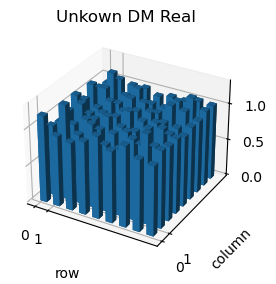

[[1.17780749 0.95841826 0.92122589 0.98952452 1.11697835 0.97143354
  1.09673412 0.97149615 0.94596002]
 [0.95841826 1.28957031 0.93838424 1.12991239 0.90720443 0.90287625
  1.08858038 1.217028   1.04952935]
 [0.92122589 0.93838424 1.05779061 0.96818585 0.96689107 1.04234448
  0.92533925 0.95246318 1.0133901 ]
 [0.98952452 1.12991239 0.96818585 1.05867307 0.96330239 0.95440285
  1.04495076 1.09749378 1.01998694]
 [1.11697835 0.90720443 0.96689107 0.96330239 1.09226158 1.00547991
  1.03763714 0.93205642 0.95582072]
 [0.97143354 0.90287625 1.04234448 0.95440285 1.00547991 1.04309394
  0.94321004 0.92654907 0.99499769]
 [1.09673412 1.08858038 0.92533925 1.04495076 1.03763714 0.94321004
  1.09681561 1.06808442 0.98525981]
 [0.97149615 1.217028   0.95246318 1.09749378 0.93205642 0.92654907
  1.06808442 1.16269998 1.03639471]
 [0.94596002 1.04952935 1.0133901  1.01998694 0.95582072 0.99499769
  0.98525981 1.03639471 1.02128742]]


In [73]:
bar_plot_3d(unkown_dm.real + 1, title="Unkown DM Real")
print(unkown_dm.real + 1)

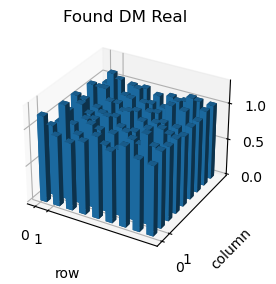

[[1.17699525 0.96085805 0.92062278 0.98997126 1.11407727 0.97232467
  1.09448374 0.97427295 0.94964331]
 [0.96085805 1.28826178 0.93882465 1.12834142 0.90923049 0.90367302
  1.0865089  1.21145597 1.04423585]
 [0.92062278 0.93882465 1.05946532 0.96871212 0.96639294 1.04121181
  0.92842237 0.95352603 1.01188204]
 [0.98997126 1.12834142 0.96871212 1.05885465 0.96340418 0.95455837
  1.04447022 1.09570147 1.01740473]
 [1.11407727 0.90923049 0.96639294 0.96340418 1.09274289 1.00645891
  1.03397434 0.93496414 0.96224713]
 [0.97232467 0.90367302 1.04121181 0.95455837 1.00645891 1.04308278
  0.94484042 0.92813309 0.99639607]
 [1.09448374 1.0865089  0.92842237 1.04447022 1.03397434 0.94484042
  1.09605491 1.06884131 0.98384141]
 [0.97427295 1.21145597 0.95352603 1.09570147 0.93496414 0.92813309
  1.06884131 1.16199245 1.03351219]
 [0.94964331 1.04423585 1.01188204 1.01740473 0.96224713 0.99639607
  0.98384141 1.03351219 1.02254998]]


In [74]:
bar_plot_3d(found_dm.real + 1, title="Found DM Real")
print(found_dm.real + 1)

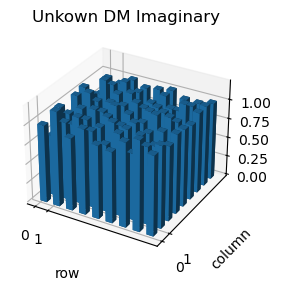

[[1.         1.22306664 0.93620154 1.10160106 0.94783809 0.91725713
  1.08864001 1.16768067 1.02940652]
 [0.77693336 1.         1.11374508 0.98938168 0.86544445 1.05518787
  0.85791396 0.99654572 1.06091837]
 [1.06379846 0.88625492 1.         0.95122898 1.06508189 1.02640777
  0.99543861 0.91548502 0.96758213]
 [0.89839894 1.01061832 1.04877102 1.         0.93623046 1.02119795
  0.93950291 1.00640853 1.02914653]
 [1.05216191 1.13455555 0.93491811 1.06376954 1.         0.93718372
  1.08669375 1.10195404 1.00349309]
 [1.08274287 0.94481213 0.97359223 0.97880205 1.06281628 1.
  1.03077445 0.95979622 0.97012801]
 [0.91135999 1.14208604 1.00456139 1.06049709 0.91330625 0.96922555
  1.         1.10543439 1.04293811]
 [0.83231933 1.00345428 1.08451498 0.99359147 0.89804596 1.04020378
  0.89456561 1.         1.04624811]
 [0.97059348 0.93908163 1.03241787 0.97085347 0.99650691 1.02987199
  0.95706189 0.95375189 1.        ]]


In [75]:
bar_plot_3d(unkown_dm.imag + 1, title="Unkown DM Imaginary")
print(unkown_dm.imag + 1)

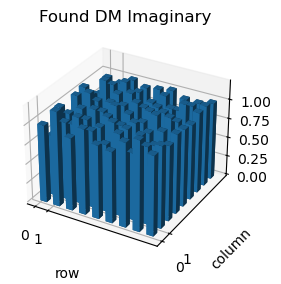

[[1.         1.22148163 0.93723918 1.10049809 0.9488005  0.91835108
  1.08598344 1.16518949 1.02716004]
 [0.77851837 1.         1.11305416 0.99051765 0.86793871 1.05289031
  0.86329419 0.99586207 1.05643596]
 [1.06276082 0.88694584 1.         0.951169   1.06413081 1.02702573
  0.99536474 0.91814706 0.97091382]
 [0.89950191 1.00948235 1.048831   1.         0.93798498 1.02099657
  0.94132124 1.00610267 1.02765223]
 [1.0511995  1.13206129 0.93586919 1.06201502 1.         0.93882372
  1.08234901 1.09741023 1.00173395]
 [1.08164892 0.94710969 0.97297427 0.97900343 1.06117628 1.
  1.02939079 0.96131599 0.97285272]
 [0.91401656 1.13670581 1.00463526 1.05867876 0.91765099 0.97060921
  1.         1.10368122 1.04176593]
 [0.83481051 1.00413793 1.08185294 0.99389733 0.90258977 1.03868401
  0.89631878 1.         1.04665271]
 [0.97283996 0.94356404 1.02908618 0.97234777 0.99826605 1.02714728
  0.95823407 0.95334729 1.        ]]


In [76]:
bar_plot_3d(found_dm.imag + 1, title="Found DM Imaginary")
print(found_dm.imag + 1)

## Reconstruct state vector from the density matrix 

In [77]:
def density_matrix_to_state_vector(rho):
    """Extracts a state vector from a pure-state density matrix."""
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(rho)

    # Find the eigenvector corresponding to eigenvalue ~1
    idx = np.argmax(eigenvalues)  # The largest eigenvalue (should be ~1 for a pure state)
    
    # Extract the corresponding eigenvector
    state_vector = eigenvectors[:, idx]

    # Normalize the state vector
    state_vector = state_vector / np.linalg.norm(state_vector)

    return state_vector

#### original psi

In [78]:
print("original psi", psi)

prob_0 = np.abs(psi[0])**2
prob_1 = np.abs(psi[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

original psi [[-0.35445185+0.22841054j]
 [ 0.36944168+0.39125842j]
 [ 0.07507777-0.22837238j]
 [ 0.15139861+0.18908074j]
 [-0.3001984 +0.04628714j]
 [-0.04934499-0.20164079j]
 [-0.07896899+0.3009643j ]
 [ 0.27222292+0.29764856j]
 [ 0.14550191-0.01079879j]]
prob_0 [0.17780749]
prob_1 [0.28957031]


#### original psi from density matrix, testing that it matches psi

In [79]:
original_psi_from_dm = density_matrix_to_state_vector(unkown_dm)
print("original_psi_from_dm", original_psi_from_dm)

prob_0 = np.abs(original_psi_from_dm[0])**2
prob_1 = np.abs(original_psi_from_dm[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

original_psi_from_dm [ 0.42167225+0.j         -0.09861152-0.5290048j  -0.1868136 +0.15129869j
 -0.02484272-0.24094793j  0.27741533+0.12370251j -0.06774565+0.19622555j
  0.22940594-0.21021067j -0.06759717-0.39765639j -0.12815635-0.06973785j]
prob_0 0.17780748810955954
prob_1 0.2895703055353728


#### statevector from reconstructed dm

In [80]:
found_psi_from_dm = density_matrix_to_state_vector(found_dm)
print("found_psi_from_dm", found_psi_from_dm)
prob_0 = np.abs(found_psi_from_dm[0])**2
prob_1 = np.abs(found_psi_from_dm[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

found_psi_from_dm [ 0.42413755+0.j         -0.09399901-0.53193836j -0.18966698+0.15031462j
 -0.0239038 -0.24222577j  0.27385924+0.12517149j -0.0672981 +0.19628491j
  0.22770075-0.20835028j -0.06263299-0.39805263j -0.12268853-0.06401581j]
prob_0 0.17989265992857334
prob_1 0.29179423145574795


### State vector fidelity

In [81]:
def statevector_fidelity(psi, phi):
    """Computes the fidelity between two state vectors."""
    psi = np.array(psi, dtype=complex)
    phi = np.array(phi, dtype=complex)
    
    # Normalize the state vectors
    psi /= np.linalg.norm(psi)
    phi /= np.linalg.norm(phi)
    
    # Compute fidelity
    fidelity = np.abs(np.vdot(psi, phi)) ** 2
    return fidelity

In [82]:
statevector_fidelity(psi, found_psi_from_dm)

0.9998805202436135